In [1]:
%load_ext autoreload
%autoreload 2

### 2. Test the Foward part of the Network
> * Now make sure that we can map from an image into an SxSx2x11 Tensor
> * First make sure that the Yolo2 weights are loadable and make sense.

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from Model.vis_utils import visualize_grid

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# l2 = np.array(list((yolo_weights['model_weights']['conv2d_1']['conv2d_1'][u'kernel:0'])))
# grid = visualize_grid(l2.transpose(3, 1, 2, 0))
# print (grid.shape, l2.shape)
# plt.imshow(grid.astype('uint8'))
# plt.axis('off')
# plt.gcf().set_size_inches(5, 5)
# plt.show()

#### 2.1 Overfit Localizer in Tiny Data
> * For debugging, we run the foward, and backward pass for `a few`
epochs.

In [4]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import NutritionDataset
from Model.net import LocalizerNet
from train import train_localizer, calculate_iou

0.4.0


In [5]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/RawImages/'
    BOXES = '../Data/FullData/BoundingBoxes.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    YOLO_PATH = '../Data/FullData/yolo.h5'
    debug = not torch.cuda.is_available()
    dataset = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, debug=debug),
        batch_size=116, shuffle=True, num_workers=8,
    )
    dev = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, split='dev', debug=debug),
        batch_size=116, shuffle=True, num_workers=8,
    )
    config = {
        'keep_prob' : 0.995
    }
    model = LocalizerNet(YOLO_PATH, use_full_yolo=True, config_params=config)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=2.5e-4, weight_decay=0.0005
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [7, 14, 35, 42, 49, 56, 63, 70, 77, 84, 91],
        gamma=0.995
    )
    r = train_localizer(
        model, optimizer, dataset, dev, epochs=100, 
        scheduler=scheduler, restore=True
    )
    return r   

In [6]:
train_losses, dev_losses, train_map, dev_map = train_localizer_network()

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0030761572998017073
	 Dev Loss =  0.008953017881140113
	 Train mAP =  [0.75   0.6875 0.5375 0.275  0.025 ]
	 Dev mAP =  [0.50923229 0.37206819 0.20458605 0.07040715 0.00597526]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0011781760258600116
	 Dev Loss =  0.005493741424288601
	 Train mAP =  [0.8875 0.7625 0.6375 0.3    0.0875]
	 Dev mAP =  [0.62756291 0.50837314 0.29357914 0.09957479 0.01297957]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0015292952302843332
	 Dev Loss =  0.004059181548655033
	 Train mAP =  [0.875  0.7875 0.625  0.3875 0.0375]
	 Dev mAP =  [0.66829275 0.57302831 0.43493224 0.17975303 0.02593488]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0009104365017265081
	 Dev Loss =  0.0035724144254345447
	 Train mAP =  [0.9375 0.8375 0.675  0.4625 0.1875]
	 Dev mAP =  [0.80227264 0.63432452 0.43030153 0.19615952 0.02497864]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0011207343777641654
	 Dev Loss =  0.0032834805024322122
	 Train mAP =  [0.9375 0.8375 0.675  0.475  0.0625]
	 Dev mAP =  [0.7529755  0.63167909 0.4696577  0.21832285 0.02823567]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0009554653079248965
	 Dev Loss =  0.003566679311916232
	 Train mAP =  [0.9375 0.85   0.725  0.45   0.1   ]
	 Dev mAP =  [0.76162046 0.6224468  0.42863661 0.1935141  0.0351429 ]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0006929172668606043
	 Dev Loss =  0.0036537008127197623
	 Train mAP =  [0.925  0.825  0.6875 0.4625 0.175 ]
	 Dev mAP =  [0.75780037 0.60442393 0.43329159 0.25385892 0.03678355]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0006611515418626368
	 Dev Loss =  0.0032371876295655966
	 Train mAP =  [0.925  0.875  0.8    0.575  0.2375]
	 Dev mAP =  [0.79215692 0.68168492 0.49277241 0.26619777 0.04660318]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0008400627411901951
	 Dev Loss =  0.003020901349373162
	 Train mAP =  [0.95   0.8875 0.8    0.5875 0.1   ]
	 Dev mAP =  [0.84578868 0.73793783 0.52816286 0.28111409 0.04760795]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.000728393264580518
	 Dev Loss =  0.0029636862745974213
	 Train mAP =  [0.9625 0.9    0.7875 0.55   0.175 ]
	 Dev mAP =  [0.83743981 0.71134281 0.51910046 0.29323451 0.05091352]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0008728920365683734
	 Dev Loss =  0.003171055839629844
	 Train mAP =  [0.9375 0.8875 0.7625 0.5125 0.1625]
	 Dev mAP =  [0.82446024 0.69704295 0.49650027 0.27954625 0.04337042]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0008385443943552673
	 Dev Loss =  0.0032819273765198886
	 Train mAP =  [0.925  0.8625 0.7625 0.5    0.1625]
	 Dev mAP =  [0.8283046  0.71891018 0.52833275 0.29360341 0.03847274]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0009445485775358975
	 Dev Loss =  0.0035811380366794765
	 Train mAP =  [0.9125 0.825  0.675  0.4875 0.1375]
	 Dev mAP =  [0.78589042 0.63640688 0.44908648 0.25459188 0.03137135]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




=== Performance Check ===
	 Train Loss =  0.0008555128588341177
	 Dev Loss =  0.0034479924070183188
	 Train mAP =  [0.9375 0.9    0.7125 0.5375 0.2   ]
	 Dev mAP =  [0.81863059 0.68051025 0.49784483 0.26152338 0.03195868]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0007256675162352622
	 Dev Loss =  0.0031468157831113786
	 Train mAP =  [0.8875 0.8    0.7    0.6    0.1875]
	 Dev mAP =  [0.83364399 0.70906629 0.5134941  0.27251767 0.03080829]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0006613802397623658
	 Dev Loss =  0.003226303990231827
	 Train mAP =  [0.975  0.875  0.75   0.5875 0.1625]
	 Dev mAP =  [0.8223536  0.7292686  0.54860788 0.30836925 0.05803918]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0011567912297323346
	 Dev Loss =  0.003246893669711426
	 Train mAP =  [0.9125 0.8875 0.775  0.525  0.1625]
	 Dev mAP =  [0.83011999 0.70620243 0.52392533 0.28767669 0.03844847]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0006659073405899107
	 Dev Loss =  0.003570227592717856
	 Train mAP =  [0.95   0.8625 0.725  0.575  0.225 ]
	 Dev mAP =  [0.78116263 0.67914143 0.49263164 0.25606264 0.02542036]


HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))

HBox(children=(IntProgress(value=0, max=317), HTML(value='')))


=== Performance Check ===
	 Train Loss =  0.0007028572144918144
	 Dev Loss =  0.0032853669254109263
	 Train mAP =  [0.9625 0.8875 0.7875 0.5375 0.175 ]
	 Dev mAP =  [0.86011766 0.73776794 0.54956897 0.32595527 0.05461226]


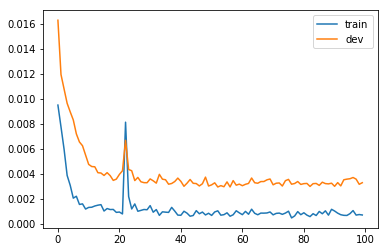

In [13]:
plt.plot(train_losses[:], label='train')
plt.plot(dev_losses[:], label='dev')
plt.legend()
plt.savefig('t_dev.png')

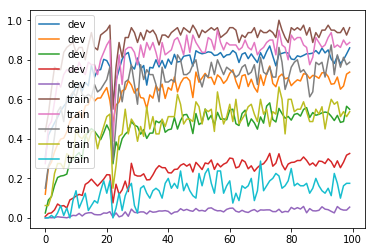

In [20]:
plt.plot(dev_map[:], label='dev')
plt.plot(train_map[:], label='train')
# plt.savefig('goals2.png')
np.save('train_map', train_map)
np.save('dev_map', dev_map)
plt.legend()

In [ ]:
def calculate_mean_image():
    '''
    calculate the mean image on the training set at 
    different sizes, (270, 480) and (540, 960)
    '''
    IMAGE_DIR = '../Data/FullData/RawImages/'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    image_paths = [os.path.join(IMAGE_DIR, f) for f in np.load(DATA_PATH).item()['train']]
    mean_270, mean_540 = np.zeros((480, 270, 3)), np.zeros((960, 540, 3))
    for img in tqdm(image_paths):
        mean_270 += resized_image((1080//4, 1920//4), img)
        mean_540 += resized_image((1080//2, 1920//2), img)
    N = len(image_paths)
    return mean_270 / N, mean_540 / N

def resized_image(size, path):
    with Image.open(path) as img:
        img = img.resize(size, resample=Image.BILINEAR)
        img = np.asarray(img)
    return img